In [4]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 33.5 MB/s eta 0:00:0000:0100:01


In [5]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.4/434.4 KB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 74.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 KB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 KB 95.9 MB/s eta 0:00:00


In [6]:
import os
import numpy as np

import torch
import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

#from brevitas.export import export_onnx_qcdq
from brevitas.export import export_qonnx

import config_aimet as config
import dataloader
import models_aimet_medium_fasdd
import utils
import val_epoch

import matplotlib.pyplot as plt

# Dataloader

In [7]:
val_loader = dataloader.get_val_loader(shuffle=False)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 6
DFire only smoke images: 13
DFire only fire images: 2
DFire smoke and fire images: 9

Test dataset len: 30


# Plot some Pics and Labels

../dfire_mini/images/AoF06872.jpg
../dfire_mini/images/AoF07484.jpg
../dfire_mini/images/AoF07856.jpg
../dfire_mini/images/AoF07878.jpg
../dfire_mini/images/AoF08019.jpg
../dfire_mini/images/AoF08122.jpg
../dfire_mini/images/AoF08143.jpg
../dfire_mini/images/AoF08281.jpg
../dfire_mini/images/AoF08304.jpg
../dfire_mini/images/PublicDataset01109.jpg
../dfire_mini/images/PublicDataset01212.jpg
../dfire_mini/images/PublicDataset01234.jpg


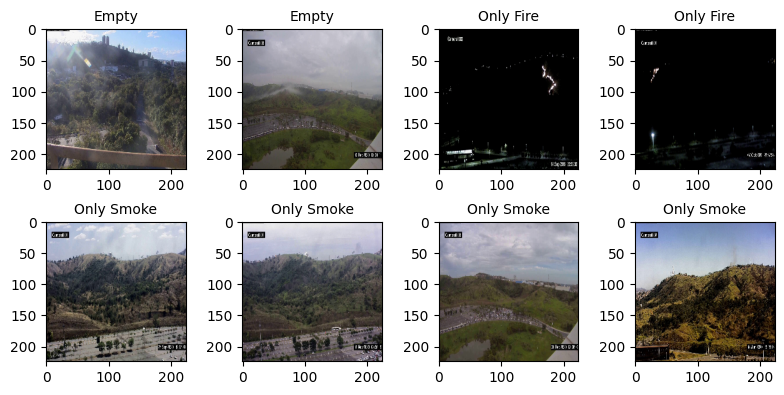

In [8]:
plt.subplots(2,4, figsize=(8, 4))

for i, (img, label) in enumerate(val_loader):

    if (i == 4):
        break
        
    for idx in range(config.BATCH_SIZE):
        plt.subplot(2, 4, (i*config.BATCH_SIZE) + idx +1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title, fontsize=10)
        
plt.tight_layout()
plt.show()

# Load Model

In [9]:
quant_model = models_aimet_medium_fasdd.QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(
        weight_bw = config.WEIGHTS_BIT_WIDTH,
        big_layers_weight_bw = config.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
        act_bw = config.ACTIVATIONS_BIT_WIDTH,
        bias_bw = config.BIAS_BIT_WIDTH,
        num_classes=config.N_CLASSES).to(config.DEVICE)

In [10]:
utils.load_checkpoint(
    model_path='./BED_classifier__best_mean_F1.pt',
    model=quant_model,
    device=config.DEVICE
)

Loading Model. Trained during 94 epochs


94

# Evaluate Model

In [11]:
quant_model.eval()
print("Set model to eval")

Set model to eval


In [12]:
with torch.no_grad():
    metrics = val_epoch.eval_fn(
        loader=val_loader,
        model=quant_model,
        device=config.DEVICE
    )

Validating:   0%|                                                                                                                                                     | 0/15 [00:00<?, ?it/s]

../dfire_mini/images/AoF06872.jpg
../dfire_mini/images/AoF07484.jpg
../dfire_mini/images/AoF07856.jpg
../dfire_mini/images/AoF07878.jpg
../dfire_mini/images/AoF08019.jpg
../dfire_mini/images/AoF08122.jpg


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)
Validating:   7%|█████████▍                                                                                                                                   | 1/15 [00:01<00:19,  1.37s/it]

../dfire_mini/images/AoF08143.jpg
../dfire_mini/images/AoF08281.jpg
../dfire_mini/images/AoF08304.jpg
../dfire_mini/images/PublicDataset01109.jpg
../dfire_mini/images/PublicDataset01212.jpg
../dfire_mini/images/PublicDataset01234.jpg
../dfire_mini/images/WEB09620.jpg
../dfire_mini/images/WEB10100.jpg
../dfire_mini/images/WEB10257.jpg
../dfire_mini/images/WEB10275.jpg
../dfire_mini/images/WEB10428.jpg
../dfire_mini/images/WEB10511.jpg
../dfire_mini/images/WEB10563.jpg
../dfire_mini/images/WEB10655.jpg


Validating:  53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 8/15 [00:01<00:00,  7.22it/s]

../dfire_mini/images/WEB10686.jpg
../dfire_mini/images/WEB10747.jpg
../dfire_mini/images/WEB10758.jpg
../dfire_mini/images/WEB10922.jpg
../dfire_mini/images/WEB11022.jpg
../dfire_mini/images/WEB11229.jpg
../dfire_mini/images/WEB11272.jpg
../dfire_mini/images/WEB11494.jpg
../dfire_mini/images/WEB11514.jpg
../dfire_mini/images/WEB11588.jpg
Out: tensor([[-0.7426, -0.3123],
        [-0.7426, -0.3123]], device='cuda:0')
tensor([[0.3224, 0.4226],
        [0.3224, 0.4226]], device='cuda:0')
Smoke Out: [0 0]
Out: tensor([[-0.7426, -0.3123],
        [-0.7426, -0.3123]], device='cuda:0')
tensor([[0.3224, 0.4226],
        [0.3224, 0.4226]], device='cuda:0')
Smoke Out: [0 0]
Out: tensor([[-0.7426, -0.3123],
        [-0.7426, -0.3123]], device='cuda:0')
tensor([[0.3224, 0.4226],
        [0.3224, 0.4226]], device='cuda:0')
Smoke Out: [0 0]
Out: tensor([[-0.7426, -0.3123],
        [-0.7426, -0.3123]], device='cuda:0')
tensor([[0.3224, 0.4226],
        [0.3224, 0.4226]], device='cuda:0')
Smoke Out: [0

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.31it/s]

Out: tensor([[-0.7426, -0.3123],
        [-0.7426, -0.3123]], device='cuda:0')
tensor([[0.3224, 0.4226],
        [0.3224, 0.4226]], device='cuda:0')
Smoke Out: [0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print(metrics)

{'Smoke': {'Precision': 0.0, 'Recall': 0.0, 'Accuracy': 0.26666666666666666, 'F1': 0.0}, 'Fire': {'Precision': 0.0, 'Recall': 0.0, 'Accuracy': 0.6333333333333333, 'F1': 0.0}}


In [14]:
import cv2

In [15]:
img_file = '../dfire_mini/images/AoF06872.jpg'
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR) 
img = img / 256.
img = np.expand_dims(img, axis=0)
img = torch.tensor(img, dtype=torch.float32)
img = torch.permute(img, (0, 3, 1, 2))

In [16]:
out_test = quant_model(img.to(config.DEVICE))

In [17]:
out_test

tensor([[-0.7426, -0.3123]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [18]:
img_file = 'WEB10495.jpg'
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR) 
img = img / 256.
img = np.expand_dims(img, axis=0)
img = torch.tensor(img, dtype=torch.float32)
img = torch.permute(img, (0, 3, 1, 2))

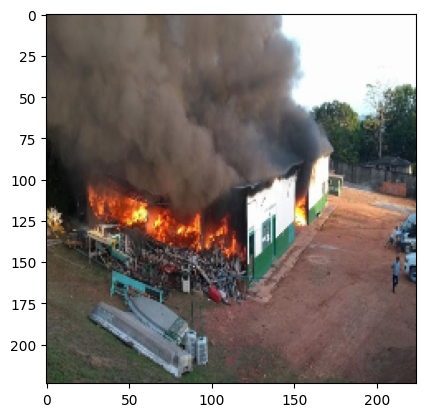

In [19]:
img_plot = img[0].permute(1, 2, 0).detach().numpy()
plt.imshow(img_plot)
plt.show()

In [20]:
out_test = quant_model(img.to(config.DEVICE))
out_test

tensor([[-0.7426, -0.3123]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [27]:
quant_model.model.conv1.__dict__

{'training': False,
 '_parameters': OrderedDict([('weight',
               Parameter containing:
               tensor([[[[ 0.3119,  0.8428,  0.2969],
                         [-0.0402,  0.8538,  0.6138],
                         [-0.1483,  0.4025,  0.1005]],
               
                        [[ 0.0020, -0.5603, -0.5621],
                         [-0.2792, -0.5801, -0.4741],
                         [-0.3693, -0.5074, -0.4561]],
               
                        [[-0.5997, -0.2994, -0.0378],
                         [-0.1915,  0.0208, -0.1792],
                         [ 0.0878,  0.5509,  0.3312]]],
               
               
                       [[[-0.0060, -0.2186, -0.2388],
                         [-0.2149, -0.4633, -0.1392],
                         [-0.0133, -0.2239, -0.2909]],
               
                        [[-0.0082,  0.1192,  0.3194],
                         [ 0.2750,  0.2334,  0.0645],
                         [ 0.3104,  0.1425,  0.2293]],
       

In [28]:
quant_model.model.conv1.weight.shape

torch.Size([32, 3, 3, 3])